In [1]:
ls -R

README.md              images_background.zip  splines.py
__pycache__/           models.ipynb           weights/
data_background.mat    own_model_bcs.ipynb
evaluate.ipynb         rdp.py

./__pycache__:
splines.cpython-37.pyc

./weights:
decoder.pth  encoder.pth


In [20]:
import splines
import torch
import glob
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
import scipy
from tqdm.notebook import tqdm
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [3]:
back_dict=splines.mat_to_dict()
spline_prims=splines.spline_dict(back_dict)
images=splines.dict_images()

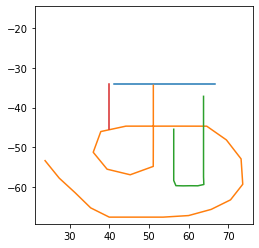

In [4]:
splines.plot_char(spline_prims['Grantha'][1][3][0])

In [5]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode=nn.Sequential(
            nn.Linear(50,1000),
            nn.ReLU(True),
            nn.Linear(1000,1000),
            nn.ReLU(True),
            nn.Linear(1000,4),
        )
        self.mu=nn.Linear(4,2)
        self.var=nn.Linear(4,2)
        
    def forward(self,x):
        x=self.encode(x)
        return [self.mu(x),self.var(x)]
    
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decode=nn.Sequential(
            nn.Linear(2,1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Linear(1000,50),
        )
        
    def forward(self,x):
        return self.decode(x)

In [6]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
def gen_latent(mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

In [8]:
enc=encoder().to(device)
dec=decoder().to(device)

In [9]:
# Model trained on gpu, therefore stored weights serialize on a cuda device
# only. Since testing on local machine, using map_location=torch.device('cpu') to map on cpu.
enc.load_state_dict(torch.load('./weights/encoder.pth',map_location=torch.device('cpu')))
dec.load_state_dict(torch.load('./weights/decoder.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
def normalize(arr):
        mu_x=np.mean(arr[:,[0]])
        mu_y=np.mean(arr[:,[1]])
        std_x=np.std(arr[:,[0]])
        std_y=np.std(arr[:,[1]])
        return np.concatenate((((arr[:,0]-mu_x)).reshape(25,1),((arr[:,1]-mu_y)).reshape(25,1)),axis=1)
def eval_char(chr):
    """
    Function to show decoded character to see how the encoder has been trained.

    Args:
        chr (numpy array): Character to be evaluated.
    """
    # spline_prims['Grantha'][1][3][0]
    pred=[]
    enc.eval()
    dec.eval()
    for prim in chr :
        prim=normalize(prim)
        prim=torch.tensor(prim).to(device).reshape(-1).unsqueeze(0).float()
        mu,var=enc(prim)
        mid=gen_latent(mu,var)
        out=dec(mid).squeeze().reshape(25,2) # generated primitive
        pred.append(out.detach().cpu().numpy())

    return splines.plot_char(pred)

Decoded


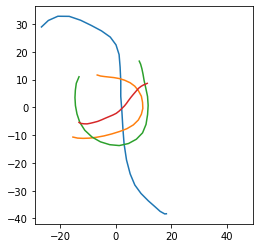

original


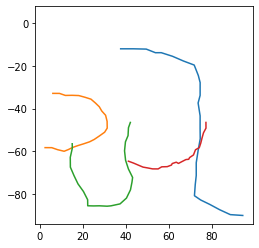

original normalized


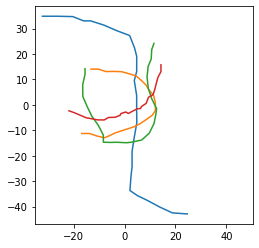

In [11]:
CHAR=spline_prims['Gujarati'][9][3][0]
# CHAR=spline_prims['Grantha'][1][3][0]
print("Decoded")
eval_char(CHAR)
print("original")
splines.plot_char(CHAR)
print('original normalized')
n=[]
for p in CHAR:
    n.append(normalize(p))
splines.plot_char(n)

In [14]:
def plot_latent_clusters(char):
    """
    Args:
        char (tensor): Latent variable of character. Should be a vector of dimension 2.
    """
    char=char.squeeze().detach().cpu().numpy()
    return plt.plot(char[0],char[1],'ro')

In [16]:
from torch.utils.data import IterableDataset, DataLoader
class OmniglotData(IterableDataset):
    """
    Iterable dataset for the 25-spline to 2 vector encoding purpose.
    Expected form to pass data in form of "spline_prims[lang][char][inst][0][primitive]"
    Args:
        data (dict): Data in the same format as used everywhere in our application.
    """
    def __init__(self,data):
        self.data=data
    
    def normalize(self,arr):
        mu_x=np.mean(arr[:,[0]])
        mu_y=np.mean(arr[:,[1]])
        std_x=np.std(arr[:,[0]])
        std_y=np.std(arr[:,[1]])
        # return np.concatenate((((arr[:,0]-mu_x)/std_x).reshape(25,1),((arr[:,1]-mu_y)/std_y).reshape(25,1)),axis=1)
        return np.concatenate((((arr[:,0]-mu_x)).reshape(25,1),((arr[:,1]-mu_y)).reshape(25,1)),axis=1)
        
    def stream(self):
        # spline_prims[lang][char][inst][0][primitive]
        for lang in self.data:
            for char in self.data[lang]:
                for inst in char:
                    for prim in inst[0]:
                        # yield torch.tensor(prim.reshape(-1)).float()
                        yield torch.tensor(self.normalize(prim).reshape(-1)).float()
    
    def __iter__(self):
        # print(count)
        return self.stream()
def gen_latent(mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
dataset=OmniglotData(spline_prims)
data_loader=DataLoader(dataset,batch_size=1,shuffle=False) # Using batchsize 1 to get single primitive at a time.

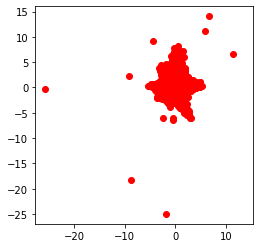

In [21]:
for i,data in tqdm(enumerate(data_loader)):
    data=data.to(device)
    mu,var=enc(data)
    lat_var=gen_latent(mu,var)
    plot_latent_clusters(lat_var)
plt.axis('square')
plt.show()